# Model Validation Test

data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we train binary classifiers on each bit of $z \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat z$ and then use kNN to find the nearest k neighbors from $z=[My]$ which is all our lower degree space's mapping.

## Target:

* Test relationship between p@k in $y \in \{0, 1\}^L$ and bit flip probability in $z \in \{0, 1\}^{\hat L}$ space

* ...


## Data Preprocess

In [25]:
%matplotlib inline
import math
import os
import data_util
import BMapModel
#from data_util import DataPoint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import faiss
import util
# import joblib # version incompatibel with sklearn's joblib and can't load the previous model

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.externals import joblib # store classifiers
from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread
from pytictoc import TicToc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
!ls -R ../data

../data:
AmazonCat  Delicious  Mediamill  README_Datasets  XMLDatasetRead
Bibtex	   Eurlex     RCV1-x	 Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt

../data/XMLDatasetRead:
XMLDatasetRead

../data/XMLDatasetRead/XMLDatasetRead:
ReadData_Matlab  README_Datasets

../data/XMLDatasetRead/XMLDatasetRead/ReadData_Matlab:
make.m	read_data.cpp  README.txt  write_data.cpp


In [4]:
ls ../data/Delicious/Delicious_data.txt

../data/Delicious/Delicious_data.txt*


In [5]:
data_dir = "../data"
model_dir = "../.model6"
train_filename = "/Delicious/Delicious_data.txt"
#test_filename = "/Eurlex/eurlex_test.txt"
tr_split_file = "/Delicious/delicious_trSplit.txt"
te_split_file = "/Delicious/delicious_tstSplit.txt"

path = os.path.dirname(train_filename)
model_path = model_dir + path
num_core = -1
L_hat_ratio = 0.5
time = TicToc()

In [6]:
tr_data, num_point, num_feature, num_label = data_util.read_file(data_dir+train_filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=16105, num_label=983, num_feature=500


In [7]:
#te_data, _, _, _ = data_util.read_file(data_dir+test_filename)

In [8]:
tr_split = data_util.split_data(data=tr_data, split_file=data_dir+tr_split_file)
te_split = data_util.split_data(data=tr_data, split_file=data_dir+te_split_file)

In [9]:
X_tr, Y_tr, X_te, Y_te = data_util.data_transform(tr_split, te_split, num_label)

In [10]:
# normalize features
X_tr = StandardScaler().fit_transform(X_tr)
X_te = StandardScaler().fit_transform(X_te)
X_te.shape

(3185, 500)

### Step 1: map to $\hat L$ space and kNN search index

We apply $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [11]:
k = sorted([Y.sum() for Y in Y_tr], reverse=True)[int(num_point*0.0001)]
k

25

In [12]:
L_hat = int(math.ceil(k * math.log(Y_tr.shape[1], 2) * L_hat_ratio))
L_hat

125

In [13]:
Z_tr = util.map_2_z(Y_tr, L_hat)
Z_te = util.map_2_z(Y_te, L_hat)

In [14]:
nn_index = faiss.index_factory(Z_tr.shape[1], "Flat", faiss.METRIC_L2)   # build the index
nn_index.add(Z_tr.astype('float32'))

### Step 2: Simulate noisy model to see the change w.p.t p@k on y

* randomly flip every bit in Z_tr w/ prob p and then use kNN to test p@1, simulation 1000 times for every point

* randomly flip every "1" w/ prob p1, and every "0" w/ p0 in Z_tr, ...


In [15]:
def flip_bits(message, p0, p1):
    '''
    randomly flip every "1" w/ prob p1, and every "0" w/ p0
    '''
    def flip(bit):
        if bit==1 and np.random.rand()<p1:
            bit = 0
        if bit==0 and np.random.rand()<p0:
            bit=1
        return bit
    np.random.seed(0)
    return np.apply_along_axis(lambda bits: np.array([flip(bit) for bit in bits]), 0, message)


In [16]:
def simulation_p_at_k(p0, p1, vote=20, pk=1, iteration=100):
    precision = []
    for _ in range(iteration):
        z_pred = flip_bits(Z_te, p0, p1)
        dist, ind = nn_index.search(z_pred.astype('float32'), vote)
        Y_pred = np.array([np.sum([Y_tr[ind[i][j]]/float(dist[i][j]*dist[i][j]+0.01) for j in range(len(ind[i]))], axis=0) for i in range(len(ind))])
        precision.append(util.precision_at_k(Y_te, Y_pred, pk))
    return np.mean(precision)

In [79]:
p_at_k = Parallel(n_jobs=num_core)\
    (delayed(simulation_p_at_k)(j, i) for j in np.arange(0, 0.6, 0.1) for i in np.arange(0, 0.6, 0.1))

In [80]:
p_at_k_2d = np.array(p_at_k).reshape(6, 6)

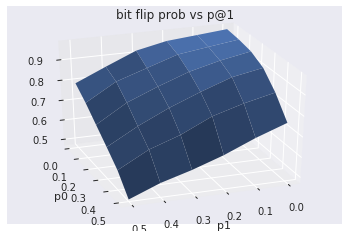

In [99]:
x_grid = np.arange(0, 0.6, 0.1)
x_grid, y_grid = np.meshgrid(x_grid, x_grid)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_grid, y_grid, p_at_k_2d)
ax.view_init(30, 70)
plt.xlabel('p1')
plt.ylabel('p0')
plt.title('bit flip prob vs p@1')